In [1]:
import torchvision
import torch.nn as nn
from torchvision.models.detection.ssd import (
    SSD, 
    DefaultBoxGenerator,
    SSDHead
)


In [2]:
import torchvision
import torch.nn as nn
from torchvision.models.detection.ssd import (
    SSD, 
    DefaultBoxGenerator,
    SSDHead
)
def create_model(num_classes=91, size=300, nms=0.45):
    model_backbone = torchvision.models.resnet34(
        weights=torchvision.models.ResNet34_Weights.DEFAULT
    )
    conv1 = model_backbone.conv1
    bn1 = model_backbone.bn1
    relu = model_backbone.relu
    max_pool = model_backbone.maxpool
    layer1 = model_backbone.layer1
    layer2 = model_backbone.layer2
    layer3 = model_backbone.layer3
    layer4 = model_backbone.layer4
    backbone = nn.Sequential(
        conv1, bn1, relu, max_pool, 
        layer1, layer2, layer3, layer4
    )
    out_channels = [512, 512, 512, 512, 512, 512]
    anchor_generator = DefaultBoxGenerator(
        [[2], [2, 3], [2, 3], [2, 3], [2], [2]],
    )
    num_anchors = anchor_generator.num_anchors_per_location()
    head = SSDHead(out_channels, num_anchors, num_classes)
    model = SSD(
        backbone=backbone,
        num_classes=num_classes,
        anchor_generator=anchor_generator,
        size=(size, size),
        head=head,
        nms_thresh=nms
    )
    return model

In [3]:
model = create_model(num_classes=91, size=300, nms=0.45)  # Example: 91 classes including background
model.eval()

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to C:\Users\User/.cache\torch\hub\checkpoints\resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:15<00:00, 5.49MB/s]


SSD(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [ ]:
image_path = 'path_to_your_image.jpg'
image = Image.open(image_path).convert("RGB")

In [20]:
batch = [
    (1, "a"),  # Image 1 with annotation 'a'
    (2, "b"),  # Image 2 with annotation 'b'
    (2, "d","d"),  # Image 3 with annotation 'c'
]

In [21]:
list(zip(*batch))

[(1, 2, 2), ('a', 'b', 'd')]

In [2]:
import cv2
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import matplotlib.patches as patches


In [3]:
def get_train_transform():
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.Blur(blur_limit=3, p=0.1),
        A.MotionBlur(blur_limit=3, p=0.1),
        A.MedianBlur(blur_limit=3, p=0.1),
        A.ToGray(p=0.3),
        A.RandomBrightnessContrast(p=0.3),
        A.ColorJitter(p=0.3),
        A.RandomGamma(p=0.3),
        ToTensorV2(p=1.0),
    ], bbox_params={
        'format': 'pascal_voc',
        'label_fields': ['labels']
    })

In [7]:
import numpy as np

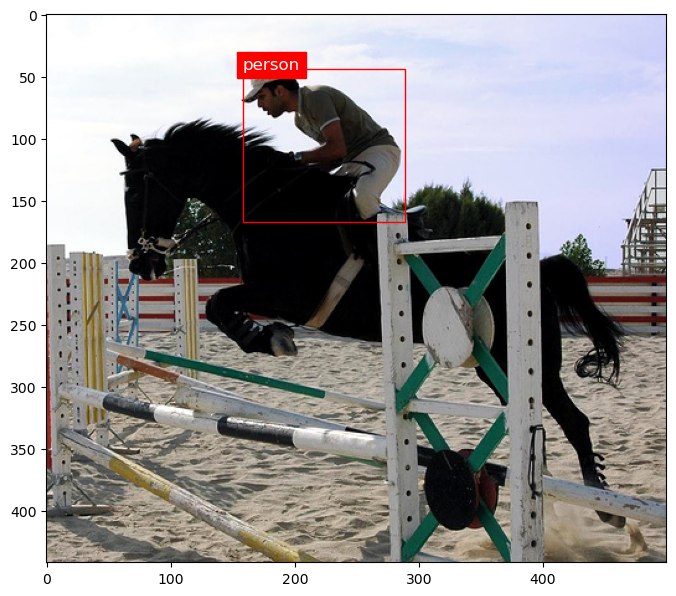

In [10]:

def parse_annotation(annotation_path):
    tree = ET.parse(annotation_path)
    root = tree.getroot()
    boxes = []
    labels = []
    for member in root.findall('object'):
        labels.append(member[0].text)
        bndbox = member.find('bndbox')
        boxes.append([int(bndbox.find('xmin').text), int(bndbox.find('ymin').text),
                      int(bndbox.find('xmax').text), int(bndbox.find('ymax').text)])
    return boxes, labels



def visualize(image, bboxes, labels):
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    # Transpose the image dimensions from (C, H, W) to (H, W, C)
    ax.imshow(np.transpose(image, (1, 2, 0)))
    for bbox, label in zip(bboxes, labels):
        xmin, ymin, xmax, ymax = bbox
        rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        plt.text(xmin, ymin, label, color='white', fontsize=12, backgroundcolor="red")
    plt.show()

# Load image and annotation
image_path = "data/Train/Train/JPEGImages/image (1).jpg"
annotation_path = "data/Train/Train/JPEGImages/image (1).xml"

# Parse XML annotation
boxes, labels = parse_annotation(annotation_path)

# Load image
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Get augmentation transform
transform = get_train_transform()

# Apply augmentation
transformed = transform(image=image, bboxes=boxes, labels=labels)
transformed_image = transformed['image']
transformed_boxes = transformed['bboxes']
transformed_labels = transformed['labels']

# Visualize the augmented image and bounding box
visualize(transformed_image, transformed_boxes, transformed_labels)

In [11]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="wbF4tzvQlCOfPXvsIGIL")
project = rf.workspace("tarslab-z5tlh").project("vehicle-detection-cyp5j")
version = project.version(1)
dataset = version.download("voc")


  Obtaining dependency information for roboflow from https://files.pythonhosted.org/packages/68/16/8d199d20167aad1a429eb8c3c4188565072136fef6825f065db48189e838/roboflow-1.1.25-py3-none-any.whl.metadata
  Obtaining dependency information for cycler==0.10.0 from https://files.pythonhosted.org/packages/f7/d2/e07d3ebb2bd7af696440ce7e754c59dd546ffe1bbe732c8ab68b9c834e61/cycler-0.10.0-py2.py3-none-any.whl.metadata
  Obtaining dependency information for idna==2.10 from https://files.pythonhosted.org/packages/a2/38/928ddce2273eaa564f6f50de919327bf3a00f091b5baba8dfa9460f3a8a8/idna-2.10-py2.py3-none-any.whl.metadata
  Obtaining dependency information for opencv-python-headless==4.8.0.74 from https://files.pythonhosted.org/packages/60/e7/a6dedca760db7a4686fd3b6053487ad4ad4d8f0591295dc8a9cf35269c42/opencv_python_headless-4.8.0.74-cp37-abi3-win_amd64.whl.metadata
  Obtaining dependency information for python-magic from https://files.pythonhosted.org/packages/6c/73/9f872cb81fc5c3bb48f7227872c28975f9

The system cannot find the path specified.
ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\User\\anaconda3\\Lib\\site-packages\\cv2\\cv2.pyd'
Consider using the `--user` option or check the permissions.



ModuleNotFoundError: No module named 'roboflow'

In [38]:
curl -L "https://universe.roboflow.com/ds/agqjA8WoWP?key=NqNu0M4yTI" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

SyntaxError: invalid syntax (3952999227.py, line 1)

In [37]:
import os

# Set the directory where your files are located
dir_path = 'PET Detection.v11i.voc/train'

# Initialize a counter for the file naming
counter = 1

# Dictionary to keep track of new names for jpg files
new_names = {}

# First pass to rename jpg files and store new names
for filename in sorted(os.listdir(dir_path)):
    if filename.endswith('.jpg'):
        new_name = f"image ({counter}).jpg"
        new_names[os.path.splitext(filename)[0]] = new_name
        os.rename(os.path.join(dir_path, filename), os.path.join(dir_path, new_name))
        counter += 1

# Second pass to rename xml files based on the new names of jpg files
for filename in sorted(os.listdir(dir_path)):
    if filename.endswith('.xml'):
        base_name = os.path.splitext(filename)[0]
        if base_name in new_names:
            new_name = new_names[base_name].replace('.jpg', '.xml')
            os.rename(os.path.join(dir_path, filename), os.path.join(dir_path, new_name))

In [39]:
counter

40

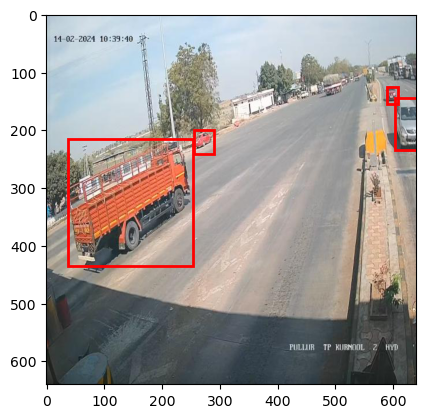

In [29]:
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

def plot_image_with_boxes(image_path, xml_path):
    # Parse the XML file
    tree = ET.parse(xml_path)
    root = tree.getroot()
    
    # Open the image
    with Image.open(image_path) as img:
        # Create a matplotlib figure and axes
        fig, ax = plt.subplots()
        # Display the image
        ax.imshow(img)
        
        # Loop over each object in the XML and get the bounding box coordinates
        for obj in root.iter('object'):
            bndbox = obj.find('bndbox')
            xmin = int(bndbox.find('xmin').text)
            xmax = int(bndbox.find('xmax').text)
            ymin = int(bndbox.find('ymin').text)
            ymax = int(bndbox.find('ymax').text)
            
            # Create a rectangle patch for the bounding box
            rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, 
                                     linewidth=2, edgecolor='r', facecolor='none')
            
            # Add the rectangle to the list of patches
            ax.add_patch(rect)
            
        # Display the plot
        plt.show()

# Replace with the actual path to your image and XML file
image_file = 'data/train/image (1010).jpg'
xml_file = 'data/train/image (1010).xml'

plot_image_with_boxes(image_file, xml_file)

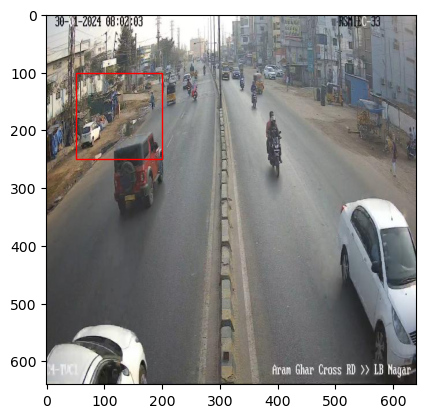

In [18]:
image_path = 'data/test/image (2).jpg'
box_coordinates = [50, 100, 200, 250]  # Replace with your actual box coordinates

plot_image_with_box(image_path, box_coordinates)

In [40]:
import xml.etree.ElementTree as ET
import os

def find_unique_classes(xml_directory):
    unique_classes = set()

    # Iterate over all xml files in the given directory
    for filename in os.listdir(xml_directory):
        if not filename.endswith('.xml'): continue
        xml_path = os.path.join(xml_directory, filename)

        # Parse XML file
        tree = ET.parse(xml_path)
        root = tree.getroot()

        # Find all 'object' elements and get the 'name' child, then add the text to the set
        for obj in root.iter('object'):
            class_name = obj.find('name').text
            unique_classes.add(class_name)

    return unique_classes


In [41]:
xml_directory = 'PET Detection.v11i.voc/train'
classes = find_unique_classes(xml_directory)
print(classes)

{'biker', 'sedan', 'motobike', 'truck', 'pedestrian', 'taxi', 'bus'}


In [42]:
len(classes)

7

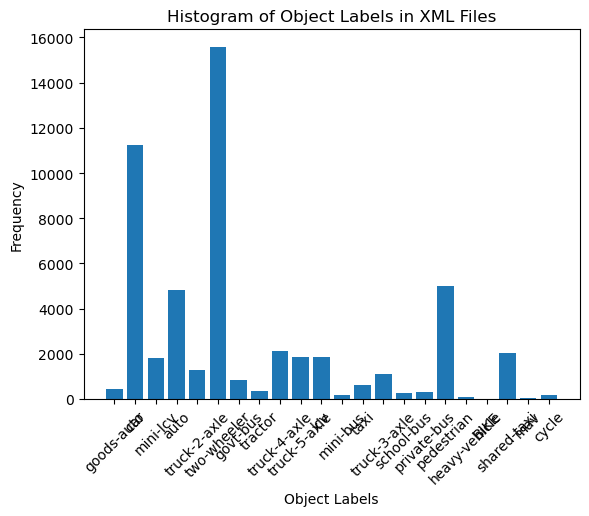

In [35]:
import os
import xml.etree.ElementTree as ET
from collections import Counter
import matplotlib.pyplot as plt

def extract_labels(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    labels = [obj.find('name').text for obj in root.iter('object')]
    return labels

def create_histogram(labels_count):
    labels, counts = zip(*labels_count.items())
    plt.bar(labels, counts)
    plt.xlabel('Object Labels')
    plt.ylabel('Frequency')
    plt.title('Histogram of Object Labels in XML Files')
    plt.xticks(rotation=45)
    plt.show()

directory = 'data/train/'  # Adjust this to your directory containing XML files
all_labels = []

# Loop through all XML files in the directory
for filename in os.listdir(directory):
    if filename.endswith('.xml'):
        labels = extract_labels(os.path.join(directory, filename))
        all_labels.extend(labels)

# Count the frequency of each label
labels_count = Counter(all_labels)

# Create and show histogram
create_histogram(labels_count)

In [ ]:
class_mapping = {
    'shared-taxi': 'car',
    'truck-5-axle': 'truck',
    'auto': 'car',
    'mav': 'car',
    'private-bus': 'bus',
    'taxi': 'car',
    'cycle': 'two-wheeler',
    'truck-4-axle': 'truck',
    'mini-lcv': 'truck',
    'lcv': 'truck',
    'goods-auto': 'truck',
    'heavy-vehicle': 'truck',
    'govt-bus': 'bus',
    'BIKE': 'two-wheeler',
    'truck-3-axle': 'truck',
    'school-bus': 'bus',
    'tractor': 'tractor',
    'two-wheeler': 'two-wheeler',
    'mini-bus': 'bus',
    'pedestrian': 'pedestrian',
    'car': 'car',
    'truck-2-axle': 'truck'
}

In [44]:
import os
import glob
from xml.etree import ElementTree as ET

def is_bbox_valid(bbox):
    """Check if the bounding box is valid."""
    x_min, y_min, x_max, y_max = bbox
    return x_max > x_min and y_max > y_min

def check_xml_for_invalid_bboxes(xml_path):
    """Check if any bounding box in the XML file is invalid."""
    tree = ET.parse(xml_path)
    root = tree.getroot()

    for obj in root.findall('object'):
        bndbox = obj.find('bndbox')
        x_min = int(bndbox.find('xmin').text)
        y_min = int(bndbox.find('ymin').text)
        x_max = int(bndbox.find('xmax').text)
        y_max = int(bndbox.find('ymax').text)
        
        if not is_bbox_valid((x_min, y_min, x_max, y_max)):
            return False
    return True

def remove_images_with_invalid_bboxes(dir_path):
    image_paths = glob.glob(os.path.join(dir_path, "*.jpg"))  # Adjust as necessary for other image formats
    initial_count = len(image_paths)

    removed_count = 0
    for image_path in image_paths:
        xml_path = image_path.rsplit(".", 1)[0] + ".xml"
        if not os.path.exists(xml_path) or not check_xml_for_invalid_bboxes(xml_path):
            os.remove(image_path)
            if os.path.exists(xml_path):
                os.remove(xml_path)
            removed_count += 1

    final_count = initial_count - removed_count
    print(f"Initial number of images: {initial_count}")
    print(f"Number of images removed: {removed_count}")
    print(f"Final number of images: {final_count}")

In [49]:
remove_images_with_invalid_bboxes('PET Detection.v11i.voc/train')


Initial number of images: 1901
Number of images removed: 0
Final number of images: 1901


In [50]:
remove_images_with_invalid_bboxes('PET Detection.v11i.voc/test')


Initial number of images: 39
Number of images removed: 0
Final number of images: 39


In [48]:
remove_images_with_invalid_bboxes('PET Detection.v11i.voc/valid')


Initial number of images: 121
Number of images removed: 0
Final number of images: 121


In [ ]:
import os
import xml.etree.ElementTree as ET
from glob import glob

# Define your directory path
directory = "data/train/"

# Truck categories that need to be mapped to 'truck'
truck_categories = ['truck-5-axle', 'truck-4-axle', 'truck-3-axle', 'truck-2-axle',"heavy-vehicle",'mini-lcv', 'lcv']
# Relevant categories (including mapped truck category)
relevant_categories = truck_categories + ['car']

# Find all XML files in the directory
xml_files = glob(os.path.join(directory, "*.xml"))

for xml_file in xml_files:
    tree = ET.parse(xml_file)
    root = tree.getroot()
    
    # Track if the current file contains relevant categories
    contains_relevant_category = False
    
    for obj in root.findall('object'):
        category = obj.find('name').text
        
        # Map truck categories to 'truck'
        if category in truck_categories:
            obj.find('name').text = 'truck'
            contains_relevant_category = True
        # Check if category is 'car'
        elif category == 'car':
            contains_relevant_category = True
        else:
            # Remove non-relevant objects
            root.remove(obj)
    
    if contains_relevant_category:
        # Save modifications
        tree.write(xml_file)
    else:
        # Remove both image and XML file as they are not relevant
        os.remove(xml_file)
        os.remove(xml_file.replace(".xml", ".jpg"))  # Assuming image extension is .jpg

In [53]:
import os
import xml.etree.ElementTree as ET
from glob import glob

# Define your directory path
directory = "data/test/"

# Truck categories that need to be mapped to 'truck'
truck_categories = ['truck-5-axle', 'truck-4-axle', 'truck-3-axle', 'truck-2-axle',"heavy-vehicle",'mini-lcv', 'lcv']
# Include 'auto' in the categories to be mapped to 'car'
car_categories = ['car', 'auto']
# Relevant categories (including mapped truck category and 'car')
relevant_categories = truck_categories + car_categories

# Find all XML files in the directory before processing
xml_files_before = glob(os.path.join(directory, "*.xml"))

# Counters
files_before = len(xml_files_before)
files_after = 0
truck_count = 0
car_count = 0

for xml_file in xml_files_before:
    tree = ET.parse(xml_file)
    root = tree.getroot()
    
    # Track if the current file contains relevant categories
    contains_relevant_category = False
    
    for obj in root.findall('object'):
        category = obj.find('name').text
        
        # Map truck categories to 'truck' and count
        if category in truck_categories:
            obj.find('name').text = 'truck'
            truck_count += 1
            contains_relevant_category = True
        # Map 'auto' to 'car', count as 'car'
        elif category in car_categories:
            obj.find('name').text = 'car'
            car_count += 1
            contains_relevant_category = True
        else:
            # Remove non-relevant objects
            root.remove(obj)
    
    if contains_relevant_category:
        # Save modifications
        tree.write(xml_file)
        files_after += 1
    else:
        # Remove both image and XML file as they are not relevant
        os.remove(xml_file)
        os.remove(xml_file.replace(".xml", ".jpg"))  # Assuming image extension is .jpg

# Find all XML files in the directory after processing
xml_files_after = glob(os.path.join(directory, "*.xml"))

# Output the results
print(f"Files before processing: {files_before}")
print(f"Files after processing: {files_after}")
print(f"Total number of 'truck' objects: {truck_count}")
print(f"Total number of 'car' objects: {car_count}")

Files before processing: 1748
Files after processing: 1572
Total number of 'truck' objects: 1441
Total number of 'car' objects: 2290


In [55]:
import torch
import torchvision
import torch.nn as nn
from torchvision.models.detection.ssd import SSD, DefaultBoxGenerator, SSDHead

def create_model(num_classes=91, size=300, nms=0.45):
    # Initialize MobileNetV2 as the backbone
    model_backbone = torchvision.models.mobilenet_v2(weights=torchvision.models.MobileNet_V2_Weights.DEFAULT).features

    # Wrap each layer in the backbone with a module that prints the output shape
    class DebugLayer(nn.Module):
        def __init__(self, layer):
            super(DebugLayer, self).__init__()
            self.layer = layer

        def forward(self, x):
            x = self.layer(x)
            print(f"Layer {self.layer.__class__.__name__} output shape: {x.shape}")
            return x

    # Wrap each layer of the backbone with DebugLayer
    for i, layer in enumerate(model_backbone):
        model_backbone[i] = DebugLayer(layer)

    backbone = model_backbone

    # Specify the out_channels as per your architecture requirement
    # This needs to be aligned with the debug output for correct integration with SSDHead
    out_channels = [32, 96, 160, 320, 960, 1280]

    # Define the DefaultBoxGenerator with appropriate scales and aspect ratios
    anchor_generator = DefaultBoxGenerator(
        aspect_ratios=[[2], [2, 3], [2, 3], [2, 3], [2], [2]]
    )

    num_anchors = anchor_generator.num_anchors_per_location()

    # Create the SSD head with the specified output channels and anchors
    head = SSDHead(out_channels, num_anchors, num_classes)

    # Create the SSD model
    model = SSD(
        backbone=backbone,
        num_classes=num_classes,
        anchor_generator=anchor_generator,
        size=(size, size),
        head=head,
        nms_thresh=nms
    )

    return model


In [ ]:
import torch
import torchvision
import torch.nn as nn
from torchvision.models.detection.ssd import SSD, DefaultBoxGenerator, SSDHead

class DebugLayer(nn.Module):
    def __init__(self, layer):
        super(DebugLayer, self).__init__()
        self.layer = layer

    def forward(self, x):
        x = self.layer(x)
        print(f"Layer {self.layer.__class__.__name__} output shape: {x.shape}")
        return x

def create_debug_backbone(backbone):
    for i, layer in enumerate(backbone.children()):
        backbone[i] = DebugLayer(layer)
    return backbone

def create_model(num_classes=91, size=300, nms=0.45):
    model_backbone = torchvision.models.mobilenet_v2(pretrained=True).features
    debug_backbone = create_debug_backbone(model_backbone)

    # Specify the out_channels. Adjust based on your debug output
    out_channels = [32, 96, 160, 320, 960, 1280]  

    anchor_generator = DefaultBoxGenerator(
        aspect_ratios=[[2], [2, 3], [2, 3], [2, 3], [2], [2]]
    )

    num_anchors = anchor_generator.num_anchors_per_location()

    head = SSDHead(out_channels, num_anchors, num_classes)

    model = SSD(
        backbone=debug_backbone,
        num_classes=num_classes,
        anchor_generator=anchor_generator,
        size=(size, size),
        head=head,
        nms_thresh=nms
    )

    return model

In [58]:
# Assuming you're using a device like 'cuda' or 'cpu'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create the model and move it to the device
model = create_model().to(device)

# Generate a dummy input tensor of shape (1, 3, 320, 320) - batch size of 1
dummy_input = torch.rand(1, 3, 224, 224).to(device)

# Forward pass through the model
with torch.no_grad():
    model.eval()  # Set the model to evaluation mode
    _ = model(dummy_input)

Layer Conv2dNormActivation output shape: torch.Size([1, 32, 150, 150])
Layer InvertedResidual output shape: torch.Size([1, 16, 150, 150])
Layer InvertedResidual output shape: torch.Size([1, 24, 75, 75])
Layer InvertedResidual output shape: torch.Size([1, 24, 75, 75])
Layer InvertedResidual output shape: torch.Size([1, 32, 38, 38])
Layer InvertedResidual output shape: torch.Size([1, 32, 38, 38])
Layer InvertedResidual output shape: torch.Size([1, 32, 38, 38])
Layer InvertedResidual output shape: torch.Size([1, 64, 19, 19])
Layer InvertedResidual output shape: torch.Size([1, 64, 19, 19])
Layer InvertedResidual output shape: torch.Size([1, 64, 19, 19])
Layer InvertedResidual output shape: torch.Size([1, 64, 19, 19])
Layer InvertedResidual output shape: torch.Size([1, 96, 19, 19])
Layer InvertedResidual output shape: torch.Size([1, 96, 19, 19])
Layer InvertedResidual output shape: torch.Size([1, 96, 19, 19])
Layer InvertedResidual output shape: torch.Size([1, 160, 10, 10])
Layer InvertedRe

RuntimeError: Given groups=1, weight of size [16, 32, 3, 3], expected input[1, 1280, 10, 10] to have 32 channels, but got 1280 channels instead

In [62]:
import os 
def check_for_next_possible_dir(base_dir):
    new_dir=base_dir
    i=1
    while os.path.exists(new_dir):
        i += 1
        new_dir = base_dir+str(i)
        
    return new_dir  

In [63]:
check_for_next_possible_dir("runs/expn")

'runs/expn2'